# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [41]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
# % matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

lets have a look at the raw data of all three data files starting with  
portfolio

In [42]:
portfolio['duration'] = portfolio['duration']*24 #make duration in hours to match transaction table later
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2


we can directly see that the channels column contains lists of different ways to advertise, it might be necessary to resolve this into non nested information

lets have a look at profile data frame

In [43]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


already the head of profile reveals that there are rows with None in gender and income and an unplausible age. we will look into this further

In [44]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


the profile id is unicode encoded and we can convert it to string to not always carry around the encoding

In [45]:
profile.id = profile.id.apply(str) #convert to non unicode strings

In [46]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


gender and income seem to have a lot of blank values, this might be worth looking at regarding features. maybe people who do not like to give gender or income have certain tendencies. obviously age==118 correlates with gender=None and Income None

lets consider split became_member_on into year,month,day columns - and think about using it later

In [47]:
def int_date_to_YMD(integer_date_YMD):
    date_string = str(integer_date_YMD)
    return date_string[:4], date_string[4:6], date_string[6:]

In [48]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


maximum and average seem to tend a bit high, something worth looking at in a distribution

Text(0.5,0,'age')

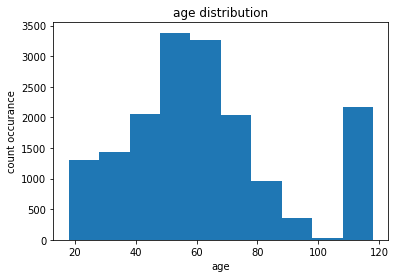

In [49]:
plt.hist(profile.age)
plt.title('age distribution')
plt.ylabel('count occurance')
plt.xlabel('age')

the average of age looks quite high for starbucks customers and the max age is probably outliers which need to be taken care of in either removing or guessing whether they substitute some other value.
first approach lets remove 118

In [50]:
profile = profile[profile.age!=118]

In [51]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


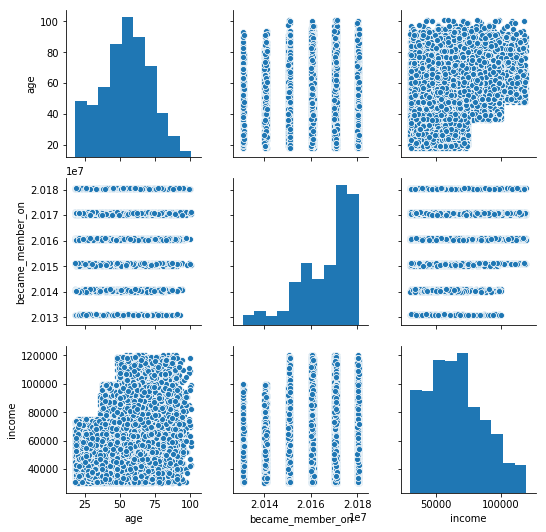

In [52]:
sns.pairplot(profile)

In [53]:
(profile.id.value_counts()>1).any()

False

checked for double ids in dataset - obviously none  
lets have a look on the income of the customres

Text(0.5,0,'income bin')

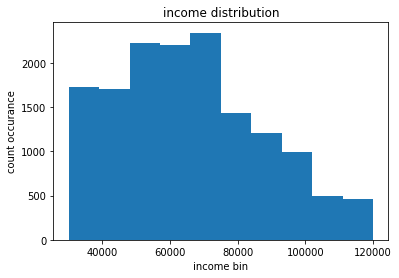

In [54]:
plt.hist(profile.dropna()['income'])
plt.title('income distribution')
plt.ylabel('count occurance')
plt.xlabel('income bin')

that so far looks quite plausible, no real suspicious behaviour int his  

now a look onto transcript

In [56]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


obiously no nan values in the dataset

In [57]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{u'offer id': u'9b98b8c7a33c4b65b9aebfe6a799e6...
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{u'offer id': u'0b1e1539f2cc45b7b9fa7c272da2e1...
2,offer received,e2127556f4f64592b11af22de27a7932,0,{u'offer id': u'2906b810c7d4411798c6938adc9daa...
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{u'offer id': u'fafdcd668e3743c1bb461111dcafc2...
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...


we can already see that there is a nested information in the value column of transcript. lets have a look into what are the unique values there 

In [58]:
transcript.iloc[24532]

event                                       offer completed
person                     94de646f7b6041228ca7dec82adb97d2
time                                                     30
value     {u'offer_id': u'f19421c1d4aa40978ebb69ca19b0e2...
Name: 24532, dtype: object

the value column contains nested information, we should split it up into separate columns

In [59]:
possible_keys = transcript['value'].apply(lambda x: str(list(x.keys())))
possible_keys.value_counts()

[u'amount']                 138953
[u'offer id']               134002
[u'offer_id', u'reward']     33579
Name: value, dtype: int64

In [60]:
[str(item) for item in list(transcript.event.unique())] #look at the unique non unicode strings

['offer received', 'offer viewed', 'transaction', 'offer completed']

create separate columns for offer id, amount and reward independant of 'offer_id' or 'offer id'

In [61]:
transcript['offer_id'] = transcript.value.apply(lambda x: list(x.values())[0] if 'offer' in str(list(x.keys())[0]) else None)
transcript['amount'] = transcript.value.apply(lambda x: list(x.values())[0] if (list(x.keys())[0])==u'amount' else None)
transcript['reward'] = transcript.value.apply(lambda x: list(x.values())[1] if len(x.keys())==2 else None)
transcript.drop('value',axis=1,inplace=True)

how about the distribution of the data

we see quite many outliers regarding extremely high spendings. we might consider excluding these if models cannot handle it correctly. since they might still be correct - maybe someone celebrating his birthday or a larger work-group-gathering they are not truly implausible

{'boxes': [<matplotlib.lines.Line2D at 0x7f65228d6c50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f652189d4d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f651a36f050>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f652189dc50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f65228d6d10>,
  <matplotlib.lines.Line2D at 0x7f652189d110>]}

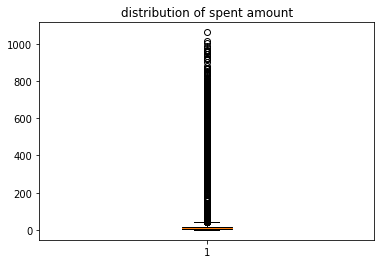

In [62]:
data = transcript[transcript['amount']>0]['amount'].dropna().values.squeeze()
fig1, ax1 = plt.subplots()
ax1.set_title('distribution of spent amount')
ax1.boxplot(data)

unfortunately there is no information in the transcript table about when an informational offer is completed. for a compensation we will proceed as follows. 
- so far for all other offers there is a **offer received**, **offer viewed** and **offer completed** entry. we will enrich the table by a calculated completion row for valid data points of informational offer completed
- first we sort the data frame for person and continue to work on a copy - adding some helper columns as offer_type
- excluding the rows we dont need for computation: only keep transactions and informational offers viewed
- by shifting event and person columns we make sure we only process rows that belong together. we compare the shifted rows with the original entries in a row and decide whether a record is to be kept or not
- by logical combination of the keep_* columns we have created a criteria a data frame that holds an informational offer followed by the nearest transaction
- we replace **transaction** in the event column by **offer_id** from the previous row to match the row entries from the original transcript table
- now we will check if the time of the nearest transaction is still within the duration period allowed for the informational offer
- setting **amount** and **offer_type** colmn to **np.nan** and **informational** resectively to match the original transcript table format
- reducint the amount of columns to the ones necessary

In [63]:
def lookup_dictionary(look_up_df,search, result):
    '''
    function to create a lookup dictionary between search and result for example offer id -> offer type
    
    '''
    temp_df = look_up_df.copy()
    dic= dict(zip(temp_df[search],temp_df[result]))
    dic[None] = None
    return dic

create a dictionary that holds the information necessary for translating an offer id to an offer type

In [64]:
look_up_offer_type = lookup_dictionary(portfolio,'id','offer_type' )

now we sort the transcript for person and time and enrich it with the offer_type

In [65]:
transcript.head(2)

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


In [66]:
transcript.sort_values(['person','time'],inplace=True)
trans_enriched = transcript.copy()

# create new column offer_type
trans_enriched['offer_type'] = trans_enriched['offer_id'].apply(lambda x:look_up_offer_type[x]) 

In [67]:
trans_enriched.head(2)

,event,person,time,offer_id,amount,reward,offer_type
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational


## evaluate time deltas until completion

for later feature engineering we would like to know how much time passed between the different events regarding offers (received, viewed, completed). this is the target of this chapter. unfortunately informational offer does not have an offer completed timestamp in the transaction data. this is the first goal to creat this status.  

for this we first set x hours as duration a customer needs to make a transaction after viewing an informational offer and being within the offer-duration after receiving the offer

In [68]:
manual = 1
hrs_to_complete_informational_offer = 24

if manual:
    duration = hrs_to_complete_informational_offer
else:
    duration = trans['offer_id'].apply(lambda x: lookup_duration[x])

In [69]:
# select only rows with informational offers or transactions
inf_trans = trans_enriched[(trans_enriched['offer_type']=='informational')|(trans_enriched['offer_type'].isnull())].copy()
print(len(inf_trans))


# by the following shifting operations we create a dataset that contains only an alternation of transactions
# and the corresponding offer views of informational offers.
# the up-shift as well as the down-shift can lead to overlapping of 'person' id's which dont match and thus have to be excluded
inf_trans['connected_transaction_down_shift'] = (inf_trans['event']=='transaction') & (inf_trans['event'].shift(1)=='offer viewed') & (inf_trans['person']==inf_trans['person'].shift(1))
inf_trans['connected_transaction_up_shift'] = (inf_trans['event']=='offer viewed') & (inf_trans['event'].shift(-1)=='transaction') & (inf_trans['person']==inf_trans['person'].shift(-1))
# trans['person_shift'] = trans['person'].shift(-1)
inf_trans = inf_trans[inf_trans['connected_transaction_down_shift'] | inf_trans['connected_transaction_up_shift']]

165019


check if time between offer received and transaction completed is within duration  
a time can be set as default from the portolio data frame corresponding to each informational offer or chosen manually. 

In [70]:
# here we actually set the offer_id of the informational offer to the value of the offer_viewed at the position right above the transaction.
# with this we are allowed create the offer_completed event for informational offer and append it to the initial transaction data frame
inf_trans.loc[inf_trans['offer_id'].isnull(),'offer_id'] = inf_trans['offer_id'].shift(1)

In [71]:
inf_trans.head(3)

,event,person,time,offer_id,amount,reward,offer_type,connected_transaction_down_shift,connected_transaction_up_shift
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational,False,True
89291,transaction,0009655768c64bdeb2e877511632db8f,228,5a8bc65990b245e5a138643cd4eb9837,22.16,NaN,None,True,False
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational,False,True


we see, the transaction event holds the offer_id now.  
we can rename the event typ to offer_completed_simulated for now and remove the helper columns as well as the rows that do not contain the simulated completed offers. then we can concat it to the original transcript datafame

In [72]:
inf_trans.drop(['connected_transaction_down_shift','connected_transaction_up_shift'],axis=1,inplace=True)
inf_trans.loc[inf_trans['event']=='transaction','event'] = 'offer completed sim'
inf_trans = inf_trans[inf_trans.event == 'offer completed sim' ]
inf_trans['offer_type'] = inf_trans['offer_id'].apply(lambda x:look_up_offer_type[x]) 
inf_trans.loc[inf_trans['event']=='offer completed sim','amount'] = np.nan
inf_trans.loc[inf_trans['event']=='offer completed sim','reward'] = 0

In [73]:
print(len(inf_trans))
inf_trans.head(3)

9083


,event,person,time,offer_id,amount,reward,offer_type
89291,offer completed sim,0009655768c64bdeb2e877511632db8f,228,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,informational
168412,offer completed sim,0009655768c64bdeb2e877511632db8f,414,3f207df678b143eea3cee63160fa8bed,NaN,0.0,informational
47805,offer completed sim,0011e0d4e6b944f998e987f904e8c1e5,132,3f207df678b143eea3cee63160fa8bed,NaN,0.0,informational


In [74]:
print('total length transcript: {} \ntotal length of offers created: {}'.format(len(trans_enriched),len(trans_enriched[(trans_enriched['event']=='offer received')])))
trans_enriched.head()

total length transcript: 306534 
total length of offers created: 76277


,event,person,time,offer_id,amount,reward,offer_type
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
89291,transaction,0009655768c64bdeb2e877511632db8f,228,None,22.16,NaN,None
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational


concatenation of simulated offer completed with original enriched transscript data. keep in mind that we still need to evaluate whether the duration where the completion was presumably done might fall out of the validity period still which will be checked later

In [75]:
# concat trans_enriched with inf_trans frame
trans_with_sim = pd.concat([trans_enriched,inf_trans],axis=0)
trans_with_sim

,event,person,time,offer_id,amount,reward,offer_type
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
89291,transaction,0009655768c64bdeb2e877511632db8f,228,None,22.16,NaN,None
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational
153401,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,bogo
168412,transaction,0009655768c64bdeb2e877511632db8f,414,None,8.57,NaN,None
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,bogo
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,bogo
204340,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,discount


In [76]:
merge_temp =  pd.merge(trans_with_sim[trans_with_sim['offer_id'].isnull()==False],
                 portfolio[['id','duration']],
                 left_on='offer_id', right_on='id', how='left').drop('id',axis=1)

# retrieve the lost rows where the id is nan and combine it with the merged df
trans_with_sim = pd.concat([trans_with_sim[trans_with_sim['offer_id'].isnull()],merge_temp],axis=0).sort_values(['person','time'])


/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



now that we have created a sufficient assumption for an informational offer to be completed, we can determin the time deltas between received, viewed and completed for all offer types. first lets do it regarding the category ``received`` to ``viewed``

In [77]:
# VIEWS
df_temp_view = pd.merge(trans_with_sim[trans_with_sim['event'] == 'offer received'][['person', 'offer_id', 'time']],
                 trans_with_sim[trans_with_sim['event'] == 'offer viewed'][['person', 'offer_id', 'time']],
                 on=['person', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

#keep entries that are equal meaning the customer checked the offer quite quickly
df_temp_view = df_temp_view[~(df_temp_view['time_viewed'] < df_temp_view['time_received'])] 

# now that all values are removed where time viewed is smaller than time received duplicates can be removed
df_temp_view.drop_duplicates(['person','offer_id','time_received'],keep='first',inplace=True)

# this handles the edgecase where a new offer is received and viewed and an older offer of the same type has never been viewed
# nevertheless it can still happen that an offer is viewed very long after having it received
df_temp_view.drop_duplicates(['person','offer_id','time_viewed'],keep='last',inplace=True) 

In [78]:
df_temp_view

,person,offer_id,time_received,time_viewed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,456.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,540.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168,216.0
8,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,576,630.0
9,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,6.0
10,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168,186.0
11,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,336,354.0


the same procedure for the categories ``received`` and ``completed``

In [79]:
# COMPLETIONS
df_temp_completed =  pd.merge(trans_with_sim[trans_with_sim['event'] == 'offer received'][['person', 'offer_id', 'time']],
                 trans_with_sim[(trans_with_sim['event'] == 'offer completed')|(trans_with_sim['event'] == 'offer completed sim')][['person', 'offer_id', 'time','reward']],
                 on=['person', 'offer_id'], how='left', suffixes=['_received', '_completed'])


df_temp_completed = df_temp_completed[~(df_temp_completed['time_completed'] < df_temp_completed['time_received'])] #keep entries that are equal meaning the customer checked the offer quite quickly
df_temp_completed.drop_duplicates(['person','offer_id','time_received'],keep='first',inplace=True) # now that all values are removed where time viewed is smaller than time received duplicates can be removed

# df_sample = df_temp_completed[df_temp_completed['person']==example_customer].copy()
# df_sample
df_temp_completed.drop_duplicates(['person','offer_id','time_completed'],keep='last',inplace=True) 

In [80]:
df_temp_joined = pd.merge(df_temp_view,df_temp_completed,how='left',on=['person','offer_id','time_received'])
df_temp_joined

,person,offer_id,time_received,time_viewed,time_completed,reward
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,228.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,414.0,0.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,456.0,414.0,5.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,540.0,528.0,2.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,2.0
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168,216.0,NaN,NaN
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,576,630.0,NaN,NaN
7,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,6.0,132.0,0.0
8,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168,186.0,252.0,3.0
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,336,354.0,576.0,0.0


we are not interested in datasets, where the customer viewed the offer after it was completed already for example customer ```ffff82501cea40309d5fdd7edcca4a07``` did so with offer ```9b98b8c7a33c4b65b9aebfe6a799e6d9```  

join the duration and potential reward to the data frame

In [81]:
df_temp_joined = df_temp_joined[~(df_temp_joined['time_viewed']>df_temp_joined['time_completed'])]
df_temp_joined

,person,offer_id,time_received,time_viewed,time_completed,reward
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,228.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,414.0,0.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,2.0
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168,216.0,NaN,NaN
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,576,630.0,NaN,NaN
7,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,6.0,132.0,0.0
8,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168,186.0,252.0,3.0
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,336,354.0,576.0,0.0
10,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,432.0,576.0,5.0
11,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,516.0,576.0,5.0


checking one specific customer

In [82]:
df_temp_joined[df_temp_joined['person']=='00116118485d4dfda04fdbaba9a87b5c']

,person,offer_id,time_received,time_viewed,time_completed,reward
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168,216.0,NaN,NaN
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,576,630.0,NaN,NaN


now we can merge again the enriched original transaction data with the enriched offer data

In [83]:
print('trans_with_sim: ',len(trans_with_sim))
merge_orig_view_1 = pd.merge(trans_with_sim.loc[trans_with_sim.event=='transaction',['person','time','amount']], 
                             df_temp_joined,
                             left_on=['person','time'],
                             right_on=['person','time_received'],
                             how='outer')
print('merge_orig_view_1: ',len(merge_orig_view_1))

('trans_with_sim: ', 315617)
('merge_orig_view_1: ', 202618)


wherever the time column is nan we set it to the time_received

In [84]:
merge_orig_view_1.loc[merge_orig_view_1['time'].isnull()==True,'time'] = merge_orig_view_1['time_received']

In [85]:
merge_orig_view_1 = pd.merge(merge_orig_view_1,
        portfolio[['id','reward','duration','offer_type']].rename(columns={'reward':'potential_reward'}),
        left_on='offer_id',
        right_on='id',
        how='left')
merge_orig_view_1.drop('id',axis=1,inplace=True)

we set the duration for informational offer to the defined value

In [86]:
merge_orig_view_1.loc[merge_orig_view_1['offer_type'] == 'informational','info_valid_after_view'] = duration

check customer

for informational offers we have to eliminate the invalid ones - meaning the ones that are completed or viewed after the chosen duration of validity 

In [87]:
merge_orig_view_1[(merge_orig_view_1['offer_type']=='informational')&(merge_orig_view_1['time_completed'].isnull()==False)]

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,offer_type,info_valid_after_view
289,00c6035df45840038a72766c6d27a0db,336.0,23.07,3f207df678b143eea3cee63160fa8bed,336.0,336.0,336.0,0.0,0.0,96.0,informational,24.0
511,012ee55a90bd4d969b0d0cdfaffdf6ab,168.0,1.51,5a8bc65990b245e5a138643cd4eb9837,168.0,180.0,192.0,0.0,0.0,72.0,informational,24.0
1162,0231c913a51e420783be6bdeb75aa842,336.0,1.50,5a8bc65990b245e5a138643cd4eb9837,336.0,342.0,396.0,0.0,0.0,72.0,informational,24.0
1510,02e6dbe7c694441a88f9160b6b0e1a35,408.0,14.82,5a8bc65990b245e5a138643cd4eb9837,408.0,414.0,420.0,0.0,0.0,72.0,informational,24.0
1600,03118ab70a404fada1a433cd6abaa491,168.0,10.98,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,168.0,0.0,0.0,72.0,informational,24.0
1744,03533ca5a4244ca3ac48b9c8ccba8332,576.0,3.41,3f207df678b143eea3cee63160fa8bed,576.0,624.0,648.0,0.0,0.0,96.0,informational,24.0
1822,037334c596b849cc8f8004e4e663b005,576.0,0.68,3f207df678b143eea3cee63160fa8bed,576.0,612.0,636.0,0.0,0.0,96.0,informational,24.0
1848,0383a12d3a2d4fbb86ec83bd0c25eead,0.0,2.65,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,0.0,0.0,0.0,72.0,informational,24.0
1970,03c0b69b3db24c70bba1622bc8dd8459,336.0,7.96,5a8bc65990b245e5a138643cd4eb9837,336.0,336.0,336.0,0.0,0.0,72.0,informational,24.0
2154,041967ceb80841ddbd306958d4f744ac,576.0,26.80,5a8bc65990b245e5a138643cd4eb9837,576.0,576.0,576.0,0.0,0.0,72.0,informational,24.0


In [88]:
# set the ones to nan which are too late completions. too late means they are not within validity period taken from portfolio data set as well as not within the chosen
# validity period (example no transaction within 24h after view)
condition =( merge_orig_view_1['offer_type']=='informational')&(merge_orig_view_1['time_received']+merge_orig_view_1['duration'] < merge_orig_view_1['time_completed'])
merge_orig_view_1.loc[condition,'time_completed'] = np.nan

# set the ones to nan which have not been viewed before completion
condition =( merge_orig_view_1['offer_type']=='informational')&(merge_orig_view_1['time_viewed']+merge_orig_view_1['info_valid_after_view'] < merge_orig_view_1['time_completed'])
merge_orig_view_1.loc[condition,'time_completed'] = np.nan
merge_orig_view_1.drop('info_valid_after_view',axis=1,inplace=True)

lets have a look if there are obvious inconsistancies - looks fine

In [89]:
merge_orig_view_1[(merge_orig_view_1['offer_type']=='informational')&(merge_orig_view_1['time_completed'].isnull()==False)]

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,offer_type
289,00c6035df45840038a72766c6d27a0db,336.0,23.07,3f207df678b143eea3cee63160fa8bed,336.0,336.0,336.0,0.0,0.0,96.0,informational
511,012ee55a90bd4d969b0d0cdfaffdf6ab,168.0,1.51,5a8bc65990b245e5a138643cd4eb9837,168.0,180.0,192.0,0.0,0.0,72.0,informational
1510,02e6dbe7c694441a88f9160b6b0e1a35,408.0,14.82,5a8bc65990b245e5a138643cd4eb9837,408.0,414.0,420.0,0.0,0.0,72.0,informational
1600,03118ab70a404fada1a433cd6abaa491,168.0,10.98,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,168.0,0.0,0.0,72.0,informational
1744,03533ca5a4244ca3ac48b9c8ccba8332,576.0,3.41,3f207df678b143eea3cee63160fa8bed,576.0,624.0,648.0,0.0,0.0,96.0,informational
1822,037334c596b849cc8f8004e4e663b005,576.0,0.68,3f207df678b143eea3cee63160fa8bed,576.0,612.0,636.0,0.0,0.0,96.0,informational
1848,0383a12d3a2d4fbb86ec83bd0c25eead,0.0,2.65,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,0.0,0.0,0.0,72.0,informational
1970,03c0b69b3db24c70bba1622bc8dd8459,336.0,7.96,5a8bc65990b245e5a138643cd4eb9837,336.0,336.0,336.0,0.0,0.0,72.0,informational
2154,041967ceb80841ddbd306958d4f744ac,576.0,26.80,5a8bc65990b245e5a138643cd4eb9837,576.0,576.0,576.0,0.0,0.0,72.0,informational
2300,047ad0135cfe4c0ea5ba019da4de9c52,576.0,20.14,3f207df678b143eea3cee63160fa8bed,576.0,582.0,588.0,0.0,0.0,96.0,informational


In [90]:
merge_orig_view_1.sort_values(['person','time','offer_id'],inplace=True)

determine which channels are available in portfolio channels column

In [91]:
channel_list=[]
for channels in portfolio.channels:
    for channel in channels:
        channel_list.append(channel)
channel_list = list(set(channel_list))
channel_list

[u'mobile', u'web', u'email', u'social']

create one-hot-encoding for the determined channels

In [92]:
for i, row in portfolio.iterrows():
    for channel in channel_list:
        if channel in row.channels:
            portfolio.loc[i,channel]=1
        else:
            portfolio.loc[i,channel]=0


In [93]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,mobile,web,email,social
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1.0,0.0,1.0,1.0
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1.0,1.0,1.0,1.0
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1.0,1.0,1.0,0.0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1.0,1.0,1.0,0.0
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0.0,1.0,1.0,0.0


merging the porftolio data to the refined transaction data

In [94]:
merge_orig_view_2 = pd.merge(merge_orig_view_1,
                             portfolio[['difficulty','id','mobile','email','social','web']], 
                             how='left',
                             left_on='offer_id',
                             right_on='id').drop('id',axis=1)

have a look at the final dataset where offers occur

In [95]:
merge_orig_view_2[merge_orig_view_2['offer_id'].isnull()==False]

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,offer_type,difficulty,mobile,email,social,web
0,0009655768c64bdeb2e877511632db8f,168.0,NaN,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,336.0,NaN,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0
6,0009655768c64bdeb2e877511632db8f,576.0,10.27,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,2.0,2.0,168.0,discount,10.0,1.0,1.0,0.0,1.0
10,00116118485d4dfda04fdbaba9a87b5c,168.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,168.0,216.0,NaN,NaN,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0
14,00116118485d4dfda04fdbaba9a87b5c,576.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,576.0,630.0,NaN,NaN,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0
15,0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,3f207df678b143eea3cee63160fa8bed,0.0,6.0,NaN,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0
17,0011e0d4e6b944f998e987f904e8c1e5,168.0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,168.0,186.0,252.0,3.0,3.0,168.0,discount,7.0,1.0,1.0,1.0,1.0
19,0011e0d4e6b944f998e987f904e8c1e5,336.0,NaN,5a8bc65990b245e5a138643cd4eb9837,336.0,354.0,NaN,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0
20,0011e0d4e6b944f998e987f904e8c1e5,408.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.0,432.0,576.0,5.0,5.0,240.0,discount,20.0,0.0,1.0,0.0,1.0
21,0011e0d4e6b944f998e987f904e8c1e5,504.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,516.0,576.0,5.0,5.0,168.0,bogo,5.0,1.0,1.0,0.0,1.0


mark transactions as offer_type ```transaction```

In [96]:
merge_orig_view_2.loc[merge_orig_view_2['offer_type'].isnull()==True,'offer_type'] = 'transaction' 

In [97]:
# create one hot encoded male-female columns. Others is linear dependant and shouldnt be a separate column
profile=pd.concat([profile, pd.get_dummies(profile['gender'])],axis=1)#.drop('O',axis=1)],axis=1)
profile

,age,became_member_on,gender,id,income,F,M,O
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,1,0,0
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,0,1,0
15,62,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0,1,0,0
16,49,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0,0,1,0
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,0,1,0


In [98]:
def month_diff(a, b):
    '''
    convert two datetime objects into a delta of months
    '''
    return 12 * (a.year - b.year) + (a.month - b.month)

In [99]:
profile['became_member_on'] = profile['became_member_on'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))


the minimum of a customer membership is considered a base_time. from this base onward the membership duration of all other members is counted

In [100]:
base_time = profile['became_member_on'].min()
profile['member_since_month'] = profile.apply(lambda x:month_diff(x['became_member_on'],base_time),axis = 1)
profile.drop(['became_member_on'],axis=1,inplace=True)

we can then merge it back into the refined transaction / offer data

In [101]:
merge_orig_view_3 = pd.merge(merge_orig_view_2,
        profile,
        left_on='person',
        right_on='id',
        how='left').drop('id',axis=1)

In [102]:
transactions =  merge_orig_view_3

as a cleansing step in the beginning we removed all customers that dont have proper values for age, income, gender. we have to repeat here for the transaction data frame

In [103]:
transactions = transactions[transactions['gender'].isnull()==False]

finally we write transactions to file to use it in the following workbooks

In [135]:
for offer in list(transactions[['offer_id']].dropna()['offer_id'].unique()):
    print(offer)
    print(float(transactions['offer_id'].value_counts()[offer])/float(transactions['offer_id'].value_counts().sum()))

5a8bc65990b245e5a138643cd4eb9837
0.10953676609
3f207df678b143eea3cee63160fa8bed
0.101955952564
2906b810c7d4411798c6938adc9daaa5
0.091568697914
2298d6c36e964ae4a3e7e9706d1fb8c2
0.102144189469
0b1e1539f2cc45b7b9fa7c272da2e1d7
0.0950767493198
9b98b8c7a33c4b65b9aebfe6a799e6d9
0.0918938343857
fafdcd668e3743c1bb461111dcafc2a4
0.103821209165
ae264e3637204a6fb9bb56bc8210ddfd
0.100005133734
4d5c57ea9a6940dd891ad53e9dbe8da0
0.103290723343
f19421c1d4aa40978ebb69ca19b0e20d
0.100706744015


In [62]:
transactions.to_csv('transactions.csv',index=False)

lets quickly check for some suspicious things we ran into during the preprocessing. one was the very high amounts on only a few spendings

In [69]:
len(transactions)

178947

In [67]:
print(len(transactions[transactions.amount>50])/len(transactions))

0


only 0.3 percent of the spending counts are larger than 50 dollars. in case this leads to problems later, we might think about excluding those

a quick last comparison of the transaction data and the raw transcript data - we see now that we have properly converted the transcript data into a data frame which contains still all transactions but only one row for each offer meaning the information about when a certain action on one offer happened is now encoded in the columns of this offer's row

In [64]:
transcript[transcript['person']=='004b041fbfe44859945daa2c7f79ee64']

,event,person,time,offer_id,amount,reward
20790,transaction,004b041fbfe44859945daa2c7f79ee64,18,None,25.62,NaN
56591,offer received,004b041fbfe44859945daa2c7f79ee64,168,3f207df678b143eea3cee63160fa8bed,NaN,NaN
124555,transaction,004b041fbfe44859945daa2c7f79ee64,336,None,24.30,NaN
133435,transaction,004b041fbfe44859945daa2c7f79ee64,354,None,21.11,NaN
145895,transaction,004b041fbfe44859945daa2c7f79ee64,390,None,19.48,NaN
204926,offer received,004b041fbfe44859945daa2c7f79ee64,504,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
219332,offer viewed,004b041fbfe44859945daa2c7f79ee64,510,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
231080,transaction,004b041fbfe44859945daa2c7f79ee64,534,None,27.92,NaN
231081,offer completed,004b041fbfe44859945daa2c7f79ee64,534,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0
248476,offer received,004b041fbfe44859945daa2c7f79ee64,576,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN


In [65]:
transactions[transactions['person']=='004b041fbfe44859945daa2c7f79ee64']

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,...,email,social,web,age,gender,income,F,M,O,member_since_month
95,004b041fbfe44859945daa2c7f79ee64,18.0,25.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,55.0,F,74000.0,1.0,0.0,0.0,58.0
96,004b041fbfe44859945daa2c7f79ee64,168.0,NaN,3f207df678b143eea3cee63160fa8bed,168.0,NaN,NaN,NaN,0.0,96.0,...,1.0,0.0,1.0,55.0,F,74000.0,1.0,0.0,0.0,58.0
97,004b041fbfe44859945daa2c7f79ee64,336.0,24.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,55.0,F,74000.0,1.0,0.0,0.0,58.0
98,004b041fbfe44859945daa2c7f79ee64,354.0,21.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,55.0,F,74000.0,1.0,0.0,0.0,58.0
99,004b041fbfe44859945daa2c7f79ee64,390.0,19.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,55.0,F,74000.0,1.0,0.0,0.0,58.0
100,004b041fbfe44859945daa2c7f79ee64,504.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,504.0,510.0,534.0,5.0,5.0,120.0,...,1.0,1.0,1.0,55.0,F,74000.0,1.0,0.0,0.0,58.0
101,004b041fbfe44859945daa2c7f79ee64,534.0,27.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,55.0,F,74000.0,1.0,0.0,0.0,58.0
102,004b041fbfe44859945daa2c7f79ee64,576.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,576.0,576.0,714.0,2.0,2.0,240.0,...,1.0,1.0,1.0,55.0,F,74000.0,1.0,0.0,0.0,58.0
103,004b041fbfe44859945daa2c7f79ee64,714.0,19.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,55.0,F,74000.0,1.0,0.0,0.0,58.0
